In [654]:
import networkx as nx
import matplotlib.pyplot as plt
import random
import numpy as np
import mxnet as mx
import logging
from sklearn.metrics import accuracy_score

In [655]:
NUM_NODE = 100
WEIGHT_MIN = .0
WEIGHT_MAX = 1.
OUT_DEGREE_MAX = 10

In [725]:
def generate_low_degree_g(node_size=20, min_out_degree=2, max_out_degree=4, weight_min=WEIGHT_MIN, weight_max=WEIGHT_MAX):
    
    G = nx.DiGraph()
    G.add_nodes_from(range(0, node_size))
    
    for node in G.nodes:
        tmp_nodes = list(G.nodes)
        tmp_nodes.remove(node)
        random.shuffle(tmp_nodes)
        
        out_neighbors = tmp_nodes[:random.randint(min_out_degree, max_out_degree)]
        
#         print(node, out_neighbors)
        
#         G.add_edges_from(map(lambda d:(node, d), out_neighbors))
        
        for out_neighbor in out_neighbors:
            G.add_edge(node, out_neighbor, weight=random.uniform(weight_min, weight_max))
        
    return G

def generate_rand_weighted_g(node_size=NUM_NODE, p=0.02, directed=True, weight_min=WEIGHT_MIN, weight_max=WEIGHT_MAX):

    rnd_g = nx.erdos_renyi_graph(node_size, p, directed=directed)

    for edge in rnd_g.edges(data=True):
        rnd_g.add_edge(edge[0], edge[1], weight=random.uniform(weight_min, weight_max))
        
    return rnd_g

def print_g(G):
    for edge in G.edges(data=True):
        print(edge)

In [726]:
G = generate_rand_weighted_g(node_size=NUM_NODE, p=0.02)
print(G.number_of_nodes())
print(G.number_of_edges())
max_out_degree = max(G.out_degree, key=lambda d: d[1])[1]
max_out_degree

100
193


8

In [729]:
G = generate_low_degree_g()
print_g(G)
print(G.number_of_nodes())
print(G.number_of_edges())

(0, 17, {'weight': 0.45124831394542864})
(0, 18, {'weight': 0.8973813012578303})
(0, 3, {'weight': 0.36397848285160306})
(1, 2, {'weight': 0.92783025136683})
(1, 15, {'weight': 0.45804535847424166})
(1, 7, {'weight': 0.32802203872629143})
(2, 0, {'weight': 0.796099079346875})
(2, 9, {'weight': 0.9615605470200249})
(2, 4, {'weight': 0.23632821956327987})
(2, 15, {'weight': 0.9646105359666273})
(3, 8, {'weight': 0.725153930161368})
(3, 4, {'weight': 0.6573540958261916})
(3, 12, {'weight': 0.9540106395787202})
(3, 14, {'weight': 0.3821006460693963})
(4, 19, {'weight': 0.3015266185819683})
(4, 15, {'weight': 0.1835814980595163})
(5, 10, {'weight': 0.8307057138433868})
(5, 12, {'weight': 0.5010072570258713})
(6, 8, {'weight': 0.8241517214817966})
(6, 14, {'weight': 0.9425768998254761})
(6, 7, {'weight': 0.6685666435281208})
(7, 9, {'weight': 0.5353718818861867})
(7, 18, {'weight': 0.6853734369499043})
(7, 6, {'weight': 0.6291875125905889})
(7, 15, {'weight': 0.05822869963193489})
(8, 17, {'

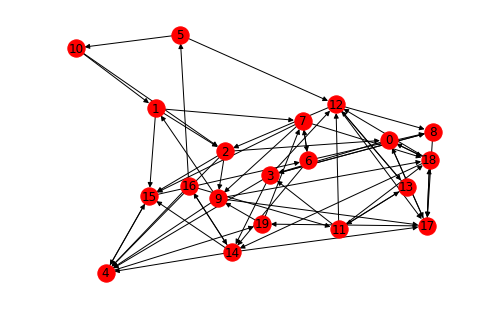

In [730]:
nx.draw(G, with_labels=True)
plt.show()

In [665]:
max_out_degree = max(G.out_degree, key=lambda d: d[1])[1]
max_out_degree

6

In [666]:
G.out_degree(93)

0

In [667]:
X, y = [], []

def one_hot_encode(idx, length=max_out_degree):
    
    ret = np.zeros(length)
    ret[idx] = 1.0
    return ret

for node in G.nodes:
    
    if G.out_degree(node) == 0:
        print('Node %d has 0 out degree' % node)
        continue

    init_weight_vec = np.ones(max_out_degree)
    
    for idx, out_edge in enumerate(G.out_edges(node)):
        init_weight_vec[idx] = G.get_edge_data(node, out_edge[1])['weight']
    
    out_neighbors = map(lambda t: (t[1], G.get_edge_data(node, t[1])['weight']),  G.out_edges(node))
#     print(node, min(out_neighbors, key=lambda d: d[1]), len(out_neighbors), sorted(out_neighbors))
    
#     label = one_hot_encode(np.argmin(init_weight_vec, axis=0))
    label = min(out_neighbors, key=lambda d: d[1])[1]
#     print(label, init_weight_vec[np.argmin(init_weight_vec)])
    assert label == init_weight_vec[np.argmin(init_weight_vec)]
    X.append(init_weight_vec)
    y.append(label)
    
features = np.array(X)
labels = np.array(y)

Node 0 has 0 out degree
Node 3 has 0 out degree
Node 11 has 0 out degree
Node 12 has 0 out degree
Node 22 has 0 out degree
Node 28 has 0 out degree
Node 36 has 0 out degree
Node 46 has 0 out degree
Node 50 has 0 out degree
Node 62 has 0 out degree
Node 66 has 0 out degree
Node 82 has 0 out degree
Node 89 has 0 out degree
Node 92 has 0 out degree
Node 93 has 0 out degree


In [671]:
print(features.shape)
print(labels.shape)

(85, 6)
(85,)


In [603]:
def augment_dataset(X, y=None, augmentation_index=10):
    
    X_aug, y_aug = [], []
    indices = np.arange(len(X[0]))
    
    for idx, x in enumerate(X):
        for _ in range(augmentation_index):
            np.random.shuffle(indices)
            
            X_aug.append(x[indices])
            y_aug.append(one_hot_encode(np.argmin(x[indices])))
            
    return np.array(X_aug), np.array(y_aug)

In [672]:
X_aug, y_aug = augment_dataset(features, labels, augmentation_index=300)
print(X_aug.shape)
print(y_aug.shape)

(25500, 6)
(25500, 6)


In [673]:
print(X_aug[0])
print(y_aug[0])

[ 0.86804124  0.82530638  1.          1.          0.81432509  0.23641207]
[ 0.  0.  0.  0.  0.  1.]


In [674]:
indices = np.arange(len(X_aug))
np.random.shuffle(indices)
X, y =  X_aug[indices], y_aug[indices]
print(X.shape)
print(y.shape)

(25500, 6)
(25500, 6)


In [675]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9, random_state=42)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(22950, 6)
(22950, 6)
(2550, 6)
(2550, 6)


In [676]:
batch_size = 100

train_iter = mx.io.NDArrayIter(X_train, y_train, batch_size, shuffle=True)
val_iter = mx.io.NDArrayIter(X_test, y_test, batch_size=len(y_test))

In [677]:
def build_model(context=mx.gpu()):
    
    data = mx.sym.var('data')
    label = mx.sym.var('softmax_label')
    
    fc2  = mx.sym.FullyConnected(data=data, num_hidden=32)
    fc2 = mx.sym.Activation(data=fc2, act_type="relu")
    
    fc3  = mx.sym.FullyConnected(data=fc2, num_hidden=max_out_degree)
    mlp  = mx.sym.SoftmaxOutput(data=fc3, label=label)
    
    return mx.mod.Module(symbol=mlp, context=context)

In [678]:
logging.getLogger().setLevel(logging.DEBUG)  # logging to stdout
model = build_model()
model.bind(data_shapes=train_iter.provide_data, label_shapes=train_iter.provide_label)
model.init_params()

In [679]:
def custom_acc(label, pred):
    tmp_label = np.argmax(label, axis=1)
    tmp_pred = np.argmax(pred, axis=1)
    return accuracy_score(tmp_label, tmp_pred)

custom_metric = mx.metric.create(custom_acc)

In [680]:
model.fit(train_iter,  # train data
              eval_data=val_iter,  # validation data
              optimizer='adam',  # use SGD to train
#               optimizer_params={'learning_rate':0.01, 'momentum': 0.9},
              eval_metric=custom_metric,  # report accuracy during training
              batch_end_callback = mx.callback.Speedometer(batch_size, 10), # output progress for each 100 data batches
              num_epoch=50)  # train for at most 10 dataset passes

INFO:root:Epoch[0] Batch [10]	Speed: 104536.15 samples/sec	custom_acc=0.248182
INFO:root:Epoch[0] Batch [20]	Speed: 91008.40 samples/sec	custom_acc=0.473000
INFO:root:Epoch[0] Batch [30]	Speed: 52460.28 samples/sec	custom_acc=0.702000
INFO:root:Epoch[0] Batch [40]	Speed: 70761.28 samples/sec	custom_acc=0.741000
INFO:root:Epoch[0] Batch [50]	Speed: 109720.98 samples/sec	custom_acc=0.833000
INFO:root:Epoch[0] Batch [60]	Speed: 111607.04 samples/sec	custom_acc=0.862000
INFO:root:Epoch[0] Batch [70]	Speed: 89301.31 samples/sec	custom_acc=0.872000
INFO:root:Epoch[0] Batch [80]	Speed: 44487.74 samples/sec	custom_acc=0.919000
INFO:root:Epoch[0] Batch [90]	Speed: 78795.87 samples/sec	custom_acc=0.927000
INFO:root:Epoch[0] Batch [100]	Speed: 57051.39 samples/sec	custom_acc=0.915000
INFO:root:Epoch[0] Batch [110]	Speed: 61402.82 samples/sec	custom_acc=0.917000
INFO:root:Epoch[0] Batch [120]	Speed: 40467.98 samples/sec	custom_acc=0.935000
INFO:root:Epoch[0] Batch [130]	Speed: 67417.37 samples/sec

INFO:root:Epoch[4] Batch [100]	Speed: 93578.99 samples/sec	custom_acc=0.967000
INFO:root:Epoch[4] Batch [110]	Speed: 98261.78 samples/sec	custom_acc=0.958000
INFO:root:Epoch[4] Batch [120]	Speed: 105943.52 samples/sec	custom_acc=0.970000
INFO:root:Epoch[4] Batch [130]	Speed: 94850.84 samples/sec	custom_acc=0.958000
INFO:root:Epoch[4] Batch [140]	Speed: 100371.02 samples/sec	custom_acc=0.980000
INFO:root:Epoch[4] Batch [150]	Speed: 99128.00 samples/sec	custom_acc=0.969000
INFO:root:Epoch[4] Batch [160]	Speed: 101062.70 samples/sec	custom_acc=0.969000
INFO:root:Epoch[4] Batch [170]	Speed: 103315.61 samples/sec	custom_acc=0.961000
INFO:root:Epoch[4] Batch [180]	Speed: 95839.14 samples/sec	custom_acc=0.963000
INFO:root:Epoch[4] Batch [190]	Speed: 101204.13 samples/sec	custom_acc=0.959000
INFO:root:Epoch[4] Batch [200]	Speed: 100069.28 samples/sec	custom_acc=0.976000
INFO:root:Epoch[4] Batch [210]	Speed: 101719.55 samples/sec	custom_acc=0.979000
INFO:root:Epoch[4] Batch [220]	Speed: 97446.7

INFO:root:Epoch[8] Batch [190]	Speed: 108156.37 samples/sec	custom_acc=0.962000
INFO:root:Epoch[8] Batch [200]	Speed: 106630.33 samples/sec	custom_acc=0.981000
INFO:root:Epoch[8] Batch [210]	Speed: 109181.17 samples/sec	custom_acc=0.980000
INFO:root:Epoch[8] Batch [220]	Speed: 104426.84 samples/sec	custom_acc=0.966000
INFO:root:Epoch[8] Train-custom_acc=0.967778
INFO:root:Epoch[8] Time cost=0.265
INFO:root:Epoch[8] Validation-custom_acc=0.957255
INFO:root:Epoch[9] Batch [10]	Speed: 105540.98 samples/sec	custom_acc=0.974545
INFO:root:Epoch[9] Batch [20]	Speed: 111743.81 samples/sec	custom_acc=0.978000
INFO:root:Epoch[9] Batch [30]	Speed: 108742.42 samples/sec	custom_acc=0.972000
INFO:root:Epoch[9] Batch [40]	Speed: 104635.25 samples/sec	custom_acc=0.968000
INFO:root:Epoch[9] Batch [50]	Speed: 92524.13 samples/sec	custom_acc=0.967000
INFO:root:Epoch[9] Batch [60]	Speed: 103422.61 samples/sec	custom_acc=0.955000
INFO:root:Epoch[9] Batch [70]	Speed: 110913.48 samples/sec	custom_acc=0.97500

INFO:root:Epoch[13] Batch [30]	Speed: 105999.75 samples/sec	custom_acc=0.977000
INFO:root:Epoch[13] Batch [40]	Speed: 106540.95 samples/sec	custom_acc=0.973000
INFO:root:Epoch[13] Batch [50]	Speed: 103724.41 samples/sec	custom_acc=0.975000
INFO:root:Epoch[13] Batch [60]	Speed: 104219.26 samples/sec	custom_acc=0.960000
INFO:root:Epoch[13] Batch [70]	Speed: 106370.72 samples/sec	custom_acc=0.977000
INFO:root:Epoch[13] Batch [80]	Speed: 105922.12 samples/sec	custom_acc=0.974000
INFO:root:Epoch[13] Batch [90]	Speed: 104988.84 samples/sec	custom_acc=0.980000
INFO:root:Epoch[13] Batch [100]	Speed: 108539.81 samples/sec	custom_acc=0.982000
INFO:root:Epoch[13] Batch [110]	Speed: 109589.11 samples/sec	custom_acc=0.973000
INFO:root:Epoch[13] Batch [120]	Speed: 100081.22 samples/sec	custom_acc=0.983000
INFO:root:Epoch[13] Batch [130]	Speed: 103778.31 samples/sec	custom_acc=0.971000
INFO:root:Epoch[13] Batch [140]	Speed: 110312.56 samples/sec	custom_acc=0.989000
INFO:root:Epoch[13] Batch [150]	Spe

INFO:root:Epoch[17] Batch [110]	Speed: 86213.85 samples/sec	custom_acc=0.975000
INFO:root:Epoch[17] Batch [120]	Speed: 101635.75 samples/sec	custom_acc=0.987000
INFO:root:Epoch[17] Batch [130]	Speed: 110828.48 samples/sec	custom_acc=0.976000
INFO:root:Epoch[17] Batch [140]	Speed: 111657.54 samples/sec	custom_acc=0.988000
INFO:root:Epoch[17] Batch [150]	Speed: 112474.97 samples/sec	custom_acc=0.980000
INFO:root:Epoch[17] Batch [160]	Speed: 104374.87 samples/sec	custom_acc=0.980000
INFO:root:Epoch[17] Batch [170]	Speed: 94598.40 samples/sec	custom_acc=0.976000
INFO:root:Epoch[17] Batch [180]	Speed: 95913.65 samples/sec	custom_acc=0.974000
INFO:root:Epoch[17] Batch [190]	Speed: 101947.01 samples/sec	custom_acc=0.970000
INFO:root:Epoch[17] Batch [200]	Speed: 101947.01 samples/sec	custom_acc=0.984000
INFO:root:Epoch[17] Batch [210]	Speed: 100785.85 samples/sec	custom_acc=0.983000
INFO:root:Epoch[17] Batch [220]	Speed: 102352.52 samples/sec	custom_acc=0.971000
INFO:root:Epoch[17] Train-custo

INFO:root:Epoch[21] Batch [190]	Speed: 100534.61 samples/sec	custom_acc=0.969000
INFO:root:Epoch[21] Batch [200]	Speed: 94671.00 samples/sec	custom_acc=0.984000
INFO:root:Epoch[21] Batch [210]	Speed: 102700.88 samples/sec	custom_acc=0.984000
INFO:root:Epoch[21] Batch [220]	Speed: 98520.28 samples/sec	custom_acc=0.971000
INFO:root:Epoch[21] Train-custom_acc=0.971111
INFO:root:Epoch[21] Time cost=0.302
INFO:root:Epoch[21] Validation-custom_acc=0.970588
INFO:root:Epoch[22] Batch [10]	Speed: 78125.13 samples/sec	custom_acc=0.980909
INFO:root:Epoch[22] Batch [20]	Speed: 75500.95 samples/sec	custom_acc=0.990000
INFO:root:Epoch[22] Batch [30]	Speed: 97732.87 samples/sec	custom_acc=0.979000
INFO:root:Epoch[22] Batch [40]	Speed: 67454.23 samples/sec	custom_acc=0.981000
INFO:root:Epoch[22] Batch [50]	Speed: 103102.28 samples/sec	custom_acc=0.980000
INFO:root:Epoch[22] Batch [60]	Speed: 95979.50 samples/sec	custom_acc=0.980000
INFO:root:Epoch[22] Batch [70]	Speed: 112135.17 samples/sec	custom_acc

INFO:root:Epoch[26] Batch [40]	Speed: 111432.09 samples/sec	custom_acc=0.980000
INFO:root:Epoch[26] Batch [50]	Speed: 103744.94 samples/sec	custom_acc=0.983000
INFO:root:Epoch[26] Batch [60]	Speed: 105631.35 samples/sec	custom_acc=0.980000
INFO:root:Epoch[26] Batch [70]	Speed: 112171.16 samples/sec	custom_acc=0.984000
INFO:root:Epoch[26] Batch [80]	Speed: 110556.80 samples/sec	custom_acc=0.977000
INFO:root:Epoch[26] Batch [90]	Speed: 102395.00 samples/sec	custom_acc=0.982000
INFO:root:Epoch[26] Batch [100]	Speed: 106109.69 samples/sec	custom_acc=0.989000
INFO:root:Epoch[26] Batch [110]	Speed: 108458.42 samples/sec	custom_acc=0.980000
INFO:root:Epoch[26] Batch [120]	Speed: 111110.33 samples/sec	custom_acc=0.989000
INFO:root:Epoch[26] Batch [130]	Speed: 102290.12 samples/sec	custom_acc=0.981000
INFO:root:Epoch[26] Batch [140]	Speed: 110000.10 samples/sec	custom_acc=0.991000
INFO:root:Epoch[26] Batch [150]	Speed: 102450.02 samples/sec	custom_acc=0.983000
INFO:root:Epoch[26] Batch [160]	Sp

INFO:root:Epoch[30] Batch [120]	Speed: 105785.87 samples/sec	custom_acc=0.989000
INFO:root:Epoch[30] Batch [130]	Speed: 109039.26 samples/sec	custom_acc=0.981000
INFO:root:Epoch[30] Batch [140]	Speed: 105495.85 samples/sec	custom_acc=0.990000
INFO:root:Epoch[30] Batch [150]	Speed: 107711.97 samples/sec	custom_acc=0.984000
INFO:root:Epoch[30] Batch [160]	Speed: 103744.94 samples/sec	custom_acc=0.983000
INFO:root:Epoch[30] Batch [170]	Speed: 100000.10 samples/sec	custom_acc=0.983000
INFO:root:Epoch[30] Batch [180]	Speed: 105753.86 samples/sec	custom_acc=0.979000
INFO:root:Epoch[30] Batch [190]	Speed: 103168.22 samples/sec	custom_acc=0.972000
INFO:root:Epoch[30] Batch [200]	Speed: 105030.90 samples/sec	custom_acc=0.988000
INFO:root:Epoch[30] Batch [210]	Speed: 105075.63 samples/sec	custom_acc=0.984000
INFO:root:Epoch[30] Batch [220]	Speed: 107019.39 samples/sec	custom_acc=0.973000
INFO:root:Epoch[30] Train-custom_acc=0.977778
INFO:root:Epoch[30] Time cost=0.265
INFO:root:Epoch[30] Validat

INFO:root:Epoch[34] Batch [200]	Speed: 112096.21 samples/sec	custom_acc=0.988000
INFO:root:Epoch[34] Batch [210]	Speed: 102177.98 samples/sec	custom_acc=0.984000
INFO:root:Epoch[34] Batch [220]	Speed: 108968.43 samples/sec	custom_acc=0.977000
INFO:root:Epoch[34] Train-custom_acc=0.976667
INFO:root:Epoch[34] Time cost=0.269
INFO:root:Epoch[34] Validation-custom_acc=0.971373
INFO:root:Epoch[35] Batch [10]	Speed: 113273.85 samples/sec	custom_acc=0.985455
INFO:root:Epoch[35] Batch [20]	Speed: 113870.45 samples/sec	custom_acc=0.991000
INFO:root:Epoch[35] Batch [30]	Speed: 103051.62 samples/sec	custom_acc=0.983000
INFO:root:Epoch[35] Batch [40]	Speed: 105120.40 samples/sec	custom_acc=0.985000
INFO:root:Epoch[35] Batch [50]	Speed: 99344.01 samples/sec	custom_acc=0.986000
INFO:root:Epoch[35] Batch [60]	Speed: 114065.54 samples/sec	custom_acc=0.982000
INFO:root:Epoch[35] Batch [70]	Speed: 112333.39 samples/sec	custom_acc=0.986000
INFO:root:Epoch[35] Batch [80]	Speed: 110717.31 samples/sec	custo

INFO:root:Epoch[39] Batch [40]	Speed: 109988.57 samples/sec	custom_acc=0.989000
INFO:root:Epoch[39] Batch [50]	Speed: 106825.87 samples/sec	custom_acc=0.986000
INFO:root:Epoch[39] Batch [60]	Speed: 104679.64 samples/sec	custom_acc=0.984000
INFO:root:Epoch[39] Batch [70]	Speed: 101979.24 samples/sec	custom_acc=0.986000
INFO:root:Epoch[39] Batch [80]	Speed: 107019.39 samples/sec	custom_acc=0.975000
INFO:root:Epoch[39] Batch [90]	Speed: 106123.12 samples/sec	custom_acc=0.985000
INFO:root:Epoch[39] Batch [100]	Speed: 105030.90 samples/sec	custom_acc=0.990000
INFO:root:Epoch[39] Batch [110]	Speed: 107375.56 samples/sec	custom_acc=0.985000
INFO:root:Epoch[39] Batch [120]	Speed: 106736.16 samples/sec	custom_acc=0.989000
INFO:root:Epoch[39] Batch [130]	Speed: 103593.76 samples/sec	custom_acc=0.981000
INFO:root:Epoch[39] Batch [140]	Speed: 93677.22 samples/sec	custom_acc=0.990000
INFO:root:Epoch[39] Batch [150]	Speed: 101781.26 samples/sec	custom_acc=0.988000
INFO:root:Epoch[39] Batch [160]	Spe

INFO:root:Epoch[43] Batch [120]	Speed: 92344.87 samples/sec	custom_acc=0.990000
INFO:root:Epoch[43] Batch [130]	Speed: 77310.08 samples/sec	custom_acc=0.982000
INFO:root:Epoch[43] Batch [140]	Speed: 64470.23 samples/sec	custom_acc=0.990000
INFO:root:Epoch[43] Batch [150]	Speed: 80991.45 samples/sec	custom_acc=0.988000
INFO:root:Epoch[43] Batch [160]	Speed: 64204.75 samples/sec	custom_acc=0.985000
INFO:root:Epoch[43] Batch [170]	Speed: 79555.10 samples/sec	custom_acc=0.988000
INFO:root:Epoch[43] Batch [180]	Speed: 103379.28 samples/sec	custom_acc=0.982000
INFO:root:Epoch[43] Batch [190]	Speed: 95703.55 samples/sec	custom_acc=0.975000
INFO:root:Epoch[43] Batch [200]	Speed: 95229.86 samples/sec	custom_acc=0.988000
INFO:root:Epoch[43] Batch [210]	Speed: 80103.59 samples/sec	custom_acc=0.985000
INFO:root:Epoch[43] Batch [220]	Speed: 93693.96 samples/sec	custom_acc=0.975000
INFO:root:Epoch[43] Train-custom_acc=0.980000
INFO:root:Epoch[43] Time cost=0.329
INFO:root:Epoch[43] Validation-custom

INFO:root:Epoch[47] Batch [200]	Speed: 107620.76 samples/sec	custom_acc=0.987000
INFO:root:Epoch[47] Batch [210]	Speed: 103241.86 samples/sec	custom_acc=0.986000
INFO:root:Epoch[47] Batch [220]	Speed: 99116.29 samples/sec	custom_acc=0.977000
INFO:root:Epoch[47] Train-custom_acc=0.980000
INFO:root:Epoch[47] Time cost=0.267
INFO:root:Epoch[47] Validation-custom_acc=0.971765
INFO:root:Epoch[48] Batch [10]	Speed: 109720.98 samples/sec	custom_acc=0.985455
INFO:root:Epoch[48] Batch [20]	Speed: 97369.86 samples/sec	custom_acc=0.990000
INFO:root:Epoch[48] Batch [30]	Speed: 112033.34 samples/sec	custom_acc=0.985000
INFO:root:Epoch[48] Batch [40]	Speed: 107989.29 samples/sec	custom_acc=0.991000
INFO:root:Epoch[48] Batch [50]	Speed: 96794.61 samples/sec	custom_acc=0.987000
INFO:root:Epoch[48] Batch [60]	Speed: 98077.96 samples/sec	custom_acc=0.985000
INFO:root:Epoch[48] Batch [70]	Speed: 110693.94 samples/sec	custom_acc=0.986000
INFO:root:Epoch[48] Batch [80]	Speed: 109925.15 samples/sec	custom_a

In [681]:
pred = np.argmax(model.predict(val_iter).asnumpy(), axis=1)
accuracy_score(np.argmax(y_test, axis=1)[:], pred[:])

0.97176470588235297